# Image Preprocessing and YOLOv3 Training

## Get YOLOv3 folder

In [50]:
!git clone https://github.com/ultralytics/yolov3 
%cd yolov3
!pip install -r requirements.txt

fatal: destination path 'yolov3' already exists and is not an empty directory.
/scratch/zz3505/yolov3
Defaulting to user installation because normal site-packages is not writeable


## Resize images to 320x320 and Convert bounding box information to format required by YOLOv3

In [6]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


**Work in 'yolov3' directory from now on**

In [84]:
import pickle
from PIL import Image
import os
from tqdm import tqdm  

# store resized images, from various sizes to 320x320
def resize_image_and_boxes(img, boxes, target_size=(320, 320)):
    original_width, original_height = img.size
    width_ratio = target_size[0] / original_width
    height_ratio = target_size[1] / original_height
    resized_img = img.resize(target_size, Image.LANCZOS)
    resized_boxes = []
    for box in boxes:
        resized_box = {
            'left': box['left'] * width_ratio,
            'top': box['top'] * height_ratio,
            'width': box['width'] * width_ratio,
            'height': box['height'] * height_ratio,
            'label': box['label']
        }
        resized_boxes.append(resized_box)
    return resized_img, resized_boxes

# store adjusted labels in correct format required by YOLOv3
# {class} {x_center} {y_center} {width} {height} instead of {left} {top} {width} {height} {class}
def convert_to_yolo_label(box, img_width, img_height):
    label = box['label']
    if label == 10:
        label = 0 # SVHN dataset labeled '0' as '10'

    x_center = (box['left'] + box['width'] / 2) / img_width
    y_center = (box['top'] + box['height'] / 2) / img_height
    width = box['width'] / img_width
    height = box['height'] / img_height
    return f"{label} {x_center} {y_center} {width} {height}"

# load digitStruct from train directory
with open('/scratch/zz3505/train/digitStruct.pkl', 'rb') as file:
    digit_struct = pickle.load(file)

image_directory = '/scratch/zz3505/train'
label_directory = '/scratch/zz3505/train/labels' 
os.makedirs(label_directory, exist_ok=True)
target_size = (320, 320)

for item in tqdm(digit_struct, desc="Processing Images"):
    image_path = os.path.join(image_directory, item['name'])
    label_path = os.path.join(label_directory, item['name'].replace('.png', '.txt'))

    # avoid overwritting
    if os.path.exists(label_path):
        print(f'Label file {label_path} already exists. Skipping.')
        continue

    with Image.open(image_path) as img:
        boxes = [{
            'left': item['bbox']['left'][i],
            'top': item['bbox']['top'][i],
            'width': item['bbox']['width'][i],
            'height': item['bbox']['height'][i],
            'label': item['bbox']['label'][i]
        } for i in range(len(item['bbox']['height']))]

        resized_img, resized_boxes = resize_image_and_boxes(img, boxes, target_size)

    resized_img_path = os.path.join(image_directory, 'resized_320', item['name'])
    os.makedirs(os.path.dirname(resized_img_path), exist_ok=True)

    # skip existing
    if not os.path.exists(resized_img_path):
        resized_img.save(resized_img_path)
    else:
        print(f'Image file {resized_img_path} already exists. Skipping.')

    with open(label_path, 'w') as file:
        for box in resized_boxes:
            label = convert_to_yolo_label(box, *target_size)
            file.write(label + '\n')

print('Complete resizing and converting...')


Processing Images:  76%|███████▌  | 25225/33402 [00:00<00:00, 126764.24it/s]

Label file /scratch/zz3505/train/labels/1.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/2.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/3.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/4.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/5.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/6.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/7.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/8.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/9.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/10.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/11.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/12.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/13.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/14.txt already exist

Processing Images: 100%|██████████| 33402/33402 [00:00<00:00, 117563.46it/s]

Label file /scratch/zz3505/train/labels/25920.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/25921.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/25922.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/25923.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/25924.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/25925.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/25926.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/25927.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/25928.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/25929.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/25930.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/25931.txt already exists. Skipping.
Label file /scratch/zz3505/train/labels/25932.txt already exists. Skipping.
Label file /

## Same processing for test set

In [75]:

# load digitStruct from test directory
with open('/scratch/zz3505/test/digitStruct.pkl', 'rb') as file:
    test_digit_struct = pickle.load(file)

test_image_directory = '/scratch/zz3505/test'
test_label_directory = '/scratch/zz3505/test/labels' 
os.makedirs(test_label_directory, exist_ok=True)
target_size = (320, 320)

for item in tqdm(test_digit_struct, desc="Processing Images"):
    image_path = os.path.join(test_image_directory, item['name'])
    label_path = os.path.join(test_label_directory, item['name'].replace('.png', '.txt'))

    # avoid overwritting
    if os.path.exists(label_path):
        print(f'Label file {label_path} already exists. Skipping.')
        continue

    with Image.open(image_path) as img:
        boxes = [{
            'left': item['bbox']['left'][i],
            'top': item['bbox']['top'][i],
            'width': item['bbox']['width'][i],
            'height': item['bbox']['height'][i],
            'label': item['bbox']['label'][i]
        } for i in range(len(item['bbox']['height']))]

        resized_img, resized_boxes = resize_image_and_boxes(img, boxes, target_size)

    resized_img_path = os.path.join(test_image_directory, 'resized_320', item['name'])
    os.makedirs(os.path.dirname(resized_img_path), exist_ok=True)

    # skip existing
    if not os.path.exists(resized_img_path):
        resized_img.save(resized_img_path)
    else:
        print(f'Image file {resized_img_path} already exists. Skipping.')

    with open(label_path, 'w') as file:
        for box in resized_boxes:
            label = convert_to_yolo_label(box, *target_size)
            file.write(label + '\n')

print('Complete resizing and converting...')

Processing Images: 100%|██████████| 13068/13068 [09:32<00:00, 22.84it/s]

Complete resizing and converting...


In [52]:
%pwd

'/scratch/zz3505/yolov3'

In [92]:
import os
from sklearn.model_selection import train_test_split

image_directory = '/scratch/zz3505/train/resized_320'  
label_directory = '/scratch/zz3505/train/labels'          

images = [f for f in os.listdir(image_directory) if f.endswith('.png')]
labels = [f.replace('.png', '.txt') for f in images] 

train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42)  


In [95]:
print(f'Number of images in training set: {len(train_images)}')
print(f'Number of images in validation set: {len(val_images)}')

Number of images in training set: 26721
Number of images in validation set: 6681


In [96]:

train_images_dir = os.path.join('data', 'svhn', 'images', 'train')
val_images_dir = os.path.join('data', 'svhn', 'images', 'val')
train_labels_dir = os.path.join('data', 'svhn', 'labels', 'train')
val_labels_dir = os.path.join('data', 'svhn', 'labels', 'val')

os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)


In [97]:
import shutil

def move_files(source_dir, target_dir, files):
    for file in files:
        shutil.move(os.path.join(source_dir, file), os.path.join(target_dir, file))

move_files(image_directory, train_images_dir, train_images)
move_files(image_directory, val_images_dir, val_images)
move_files(label_directory, train_labels_dir, train_labels)
move_files(label_directory, val_labels_dir, val_labels)


In [100]:
import os
from sklearn.model_selection import train_test_split

image_directory = '/scratch/zz3505/test/resized_320'  
label_directory = '/scratch/zz3505/test/labels'          

test_images = [f for f in os.listdir(image_directory) if f.endswith('.png')]
test_labels = [f.replace('.png', '.txt') for f in test_images] 


In [98]:

test_images_dir = os.path.join('data', 'svhn', 'images', 'test')
test_labels_dir = os.path.join('data', 'svhn', 'labels', 'test')

os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(test_labels_dir, exist_ok=True)

In [101]:
move_files(image_directory, test_images_dir, test_images)
move_files(label_directory, test_labels_dir, test_labels)

In [104]:
%pwd

'/scratch/zz3505/yolov3'

In [110]:
!ls -1 /scratch/zz3505/yolov3/data/svhn/images/train | wc -l
!ls -1 /scratch/zz3505/yolov3/data/svhn/images/val | wc -l
!ls -1 /scratch/zz3505/yolov3/data/svhn/images/test | wc -l
!ls -1 /scratch/zz3505/yolov3/data/svhn/labels/train | wc -l
!ls -1 /scratch/zz3505/yolov3/data/svhn/labels/val | wc -l
!ls -1 /scratch/zz3505/yolov3/data/svhn/labels/test | wc -l

26721
6681
13068
26721
6681
13068


In [111]:
data_yaml_content = """
train: data/svhn/images/train
val: data/svhn/images/val
test: data/svhn/images/test  
nc: 10
names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
"""

yaml_path = 'data/data.yaml'

with open(yaml_path, 'w') as file:
    file.write(data_yaml_content)


## Inspect converted bounding box information (normalized by 320)

In [14]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def inspect_image_info(dir, idx):

    txt_name = f'{idx}.txt'
    file_path = os.path.join('data', 'svhn', 'labels', dir, txt_name)
    
    with open(file_path, 'r') as file:
        content = file.read()
        print('{class} {x_center} {y_center} {width} {height}')
        print(content)

    img_name = f'{idx}.png'
    img_path = os.path.join('data', 'svhn', 'images', dir, img_name)
    
    img = Image.open(img_path)
    print(f'Image size: {img.size}')
    
    plt.imshow(img)
    plt.axis('off')  
    plt.show()


{class} {x_center} {y_center} {width} {height}
8.0 0.4190751445086705 0.5526315789473684 0.14450867052023122 0.5526315789473684
3.0 0.5578034682080925 0.47368421052631576 0.1676300578034682 0.5526315789473684

Image size: (320, 320)


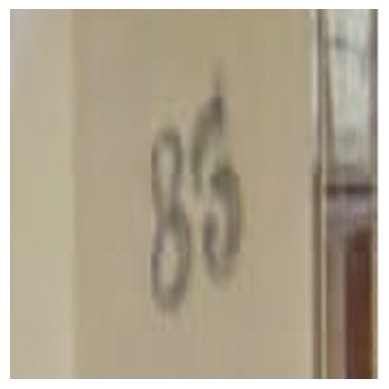

{class} {x_center} {y_center} {width} {height}
1.0 0.4431818181818182 0.47560975609756095 0.11363636363636362 0.5121951219512195
0 0.5625 0.5 0.10227272727272727 0.5121951219512195

Image size: (320, 320)


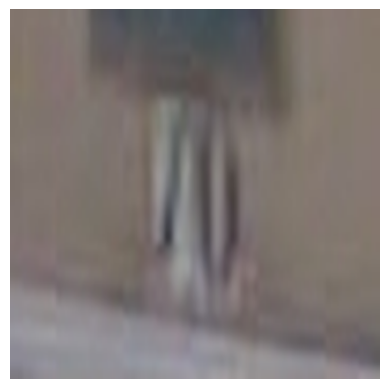

{class} {x_center} {y_center} {width} {height}
1.0 0.3924050632911392 0.42028985507246375 0.1139240506329114 0.5797101449275363
1.0 0.509493670886076 0.4782608695652174 0.08227848101265824 0.5797101449275363

Image size: (320, 320)


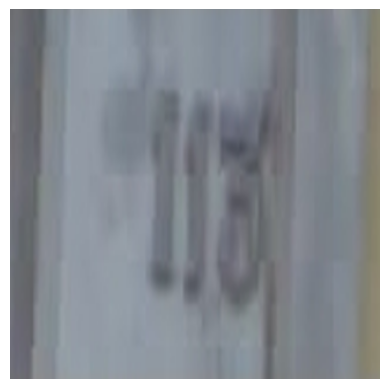

{class} {x_center} {y_center} {width} {height}
5.0 0.45555555555555555 0.41803278688524587 0.17037037037037037 0.6065573770491802
0 0.6222222222222222 0.5327868852459016 0.16296296296296295 0.6065573770491802

Image size: (320, 320)


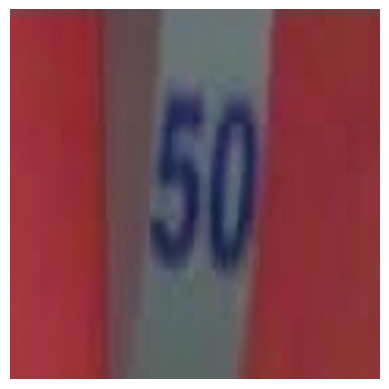

{class} {x_center} {y_center} {width} {height}
1.0 0.39090909090909093 0.475 0.09090909090909091 0.75
4.0 0.509090909090909 0.475 0.14545454545454545 0.75
2.0 0.6363636363636364 0.425 0.10909090909090909 0.75

Image size: (320, 320)


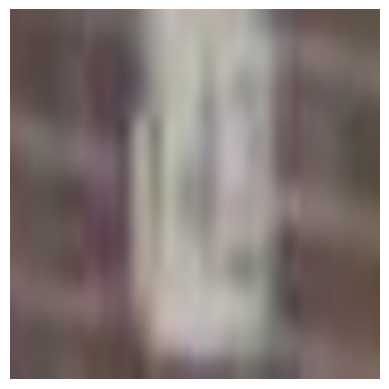

{class} {x_center} {y_center} {width} {height}
5.0 0.40625 0.4444444444444445 0.1875 0.6666666666666666
9.0 0.5859375 0.4444444444444445 0.171875 0.6666666666666666

Image size: (320, 320)


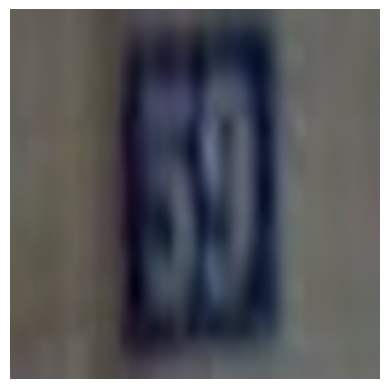

FileNotFoundError: [Errno 2] No such file or directory: 'data/svhn/labels/train/32006.txt'

In [15]:

for i in range(32000,32100):
    inspect_image_info('train', i)
    

## Gather height and width for K-means

In [19]:
import os
from PIL import Image

# extract width and height from digit_struct, rescale them for k-means
def extract_and_rescale_boxes(digit_struct, image_directory, target_width=320, target_height=320):
    
    scaled_boxes = []
    
    for entry in digit_struct:
        image_path = os.path.join(image_directory, entry['name'])
        with Image.open(image_path) as img:
            original_width, original_height = img.size

        image_num = entry['name'].split('.')[0]
        if int(image_num) % 100 == 0:
            print(f'Processing image number {image_num}...')
    
        for i in range(len(entry['bbox']['height'])):
            
            original_height_i = entry['bbox']['height'][i]
            original_width_i = entry['bbox']['width'][i]
            
            scale_width = target_width / original_width
            scale_height = target_height / original_height
            
            scaled_width = original_width_i * scale_width
            scaled_height = original_height_i * scale_height
            
            scaled_boxes.append((scaled_width, scaled_height))
    
    return scaled_boxes


In [20]:
import pickle

with open('train/digitStruct.pkl', 'rb') as file:
    digit_struct = pickle.load(file)

scaled_boxes = extract_and_rescale_boxes(digit_struct, 'train', target_width=320, target_height=320)


Processing image number 100...
Processing image number 200...
Processing image number 300...
Processing image number 400...
Processing image number 500...
Processing image number 600...
Processing image number 700...
Processing image number 800...
Processing image number 900...
Processing image number 1000...
Processing image number 1100...
Processing image number 1200...
Processing image number 1300...
Processing image number 1400...
Processing image number 1500...
Processing image number 1600...
Processing image number 1700...
Processing image number 1800...
Processing image number 1900...
Processing image number 2000...
Processing image number 2100...
Processing image number 2200...
Processing image number 2300...
Processing image number 2400...
Processing image number 2500...
Processing image number 2600...
Processing image number 2700...
Processing image number 2800...
Processing image number 2900...
Processing image number 3000...
Processing image number 3100...
Processing image 

In [22]:
len(scaled_boxes)

73257

## Perform K-means to decide 9 anchor box dimensions

In [24]:
import numpy as np
from sklearn.cluster import KMeans

X = np.array(scaled_boxes)

num_clusters = 9 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

anchors = kmeans.cluster_centers_


In [27]:

# sort from smallest to largest in terms of number of pixels i.e. width * height
sorted_anchors = sorted(anchors, key=lambda x: x[0] * x[1])

formatted_anchors = ', '.join(f'{int(w)},{int(h)}' for w, h in sorted_anchors)
print('Anchors = ', formatted_anchors)


Anchors =  20,76, 27,119, 33,152, 37,181, 44,206, 43,229, 43,256, 67,243, 60,284


## Training

In [1]:
%cd yolov3

/scratch/zz3505/yolov3


In [3]:
!python train.py --img 320 --batch 16 --epochs 3 --data data/data.yaml --cfg models/yolov3.yaml --weights yolov3.pt --name svhn_yolov3

train: weights=yolov3.pt, cfg=models/yolov3.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=3, batch_size=16, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=svhn_yolov3, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv3 is out of date by 2787 commits. Use 'git pull ultralytics master' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv3 🚀 v9.6.0-171-g4bcaa4e5 Python-3.12.1 torch-2.2.2+cu118 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, b

In [1]:
%cd /scratch/zz3505/yolov3

/scratch/zz3505/yolov3


In [2]:
!python train.py --img 320 --batch 16 --epochs 5 --data data/data.yaml --cfg models/yolov3.yaml --weights yolov3.pt --name svhn_yolov3_5

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: zz3505. Use `wandb login --relogin` to force relogin
train: weights=yolov3.pt, cfg=models/yolov3.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=16, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=svhn_yolov3_5, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv3 is out of date by 2787 commits. Use 'git pull ultralytics master' or 'git clone https://github.com/ultralytics/yolov5' to

## See predictions on test set

**After 3 Epochs**

In [3]:
!python val.py --weights runs/train/svhn_yolov3/weights/best.pt --data data/data.yaml --img 320 --conf 0.25 --iou 0.50 --task test


val: data=data/data.yaml, weights=['runs/train/svhn_yolov3/weights/best.pt'], batch_size=32, imgsz=320, conf_thres=0.25, iou_thres=0.5, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.25 > 0.001 produces invalid results
YOLOv3 🚀 v9.6.0-171-g4bcaa4e5 Python-3.12.1 torch-2.2.2+cu118 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)

Fusing layers... 
yolov3 summary: 190 layers, 61545895 parameters, 0 gradients, 154.7 GFLOPs
test: Scanning /scratch/zz3505/yolov3/data/svhn/labels/test... 13068 images, 0 b
test: WARNING ⚠️ /scratch/zz3505/yolov3/data/svhn/images/test/3192.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0152]
test: New cache created: /scratch/zz3505/yolov3/data/svhn/labels/test.cache
                 Class     Images  Instances          

In [ ]:
!python train.py --img 320 --batch 16 --epochs 2 --data data/data.yaml --cfg models/yolov3.yaml --weights runs/train/svhn_yolov3/weights/last.pt --name svhn_yolov3_continue


In [ ]:
!python train.py --img 320 --batch 16 --epochs 5 --data data/data.yaml --cfg models/yolov3.yaml --weights runs/train/svhn_yolov3/weights/last.pt --name svhn_yolov3_continue


## Run Detection Example on Images

In [9]:
!python detect.py --weights yolov3.pt --conf 0.25 --source /scratch/zz3505/StreetView/StreetView_Cropped.png

detect: weights=['yolov3.pt'], source=/scratch/zz3505/StreetView/StreetView_Cropped.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv3 🚀 v9.6.0-171-g4bcaa4e5 Python-3.12.1 torch-2.2.2+cu118 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)

Fusing layers... 
yolov3 summary: 261 layers, 61922845 parameters, 0 gradients, 155.9 GFLOPs
image 1/1 /scratch/zz3505/StreetView/StreetView_Cropped.png: 512x640 2 cars, 26.2ms
Speed: 0.5ms pre-process, 26.2ms inference, 248.3ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp14
